In [1]:
import torch
import torchvision
from torchvision import models, datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

import cv2
import numpy as np
from glob import glob

import matplotlib.pyplot as plt
%matplotlib inline

from PIL import Image
from catdog import CatsDogs

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('using device: ', device)

using device:  cuda


In [2]:
# prepare data
train_dir = './data/catdog/training_set'
test_dir = './data/catdog/test_set'
transform = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


train_data = CatsDogs(train_dir)
raw_test_data = CatsDogs(test_dir)
test_data, val_data = random_split(raw_test_data, [len(raw_test_data)//2, len(raw_test_data) - len(raw_test_data)//2])
print('trainning set: %d' % len(train_data))
print('validation set: %d' % len(val_data))
print('test set: %d' % len(test_data))

trainning set: 1000
validation set: 500
test set: 500


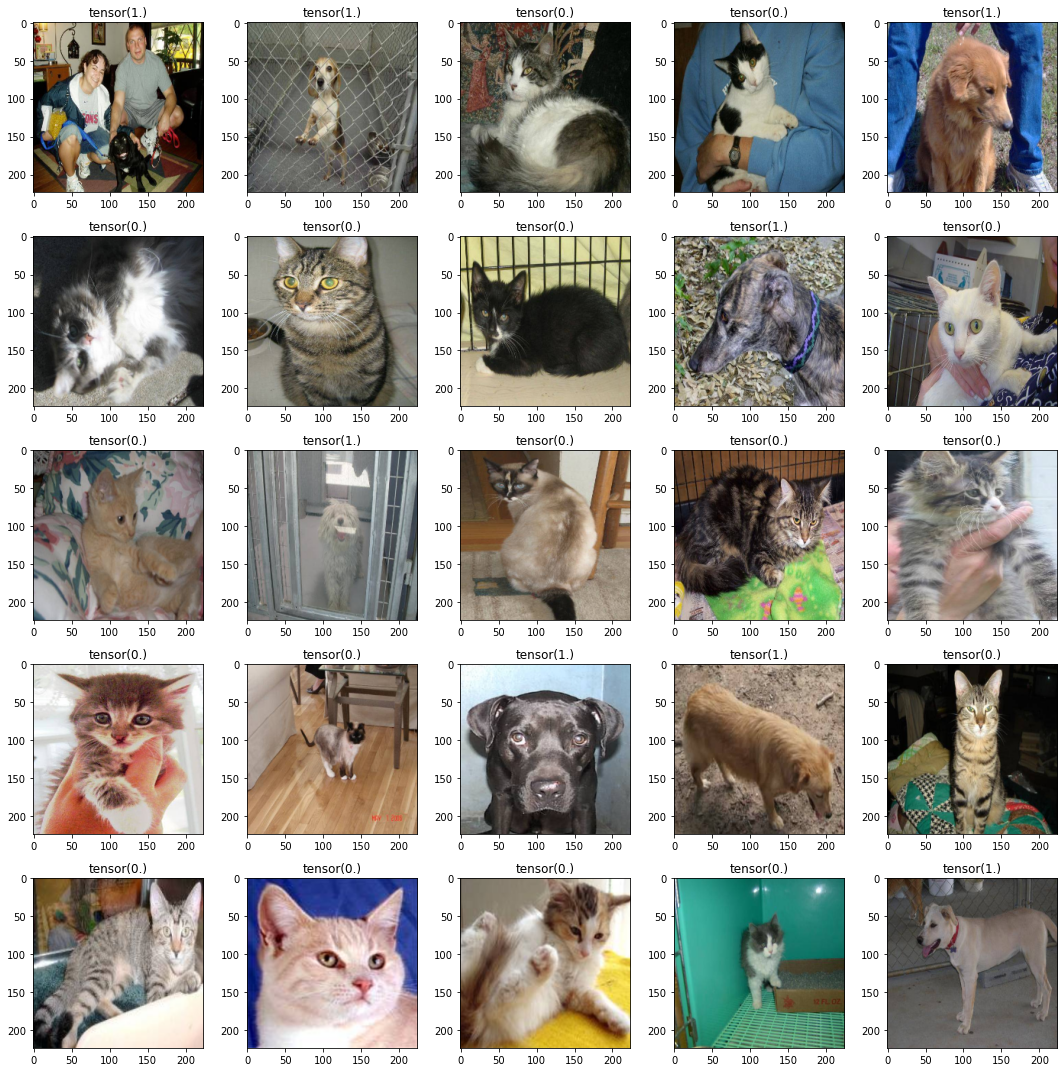

In [3]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
for i, ax in enumerate(axes.flat):
    ax.set_title(str(train_data[i][1]))
    ax.imshow(train_data[i][0].permute(1,2,0))
plt.tight_layout()
plt.show()

In [4]:
model = models.vgg16_bn(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
model.classifier = nn.Sequential(
    nn.Flatten(),
    nn.Linear(in_features=512, out_features=1024),
    nn.ReLU(),
    nn.Dropout(p=0.2),
    nn.Linear(1024, 1),
    nn.Sigmoid()
)

model = model.to(device)

lossfn = nn.BCELoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)


In [5]:
import torchsummary
print(torchsummary.summary(model, torch.zeros(1,3,224,224)))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 7, 7]           --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        (1,792)
|    └─BatchNorm2d: 2-2                  [-1, 64, 224, 224]        (128)
|    └─ReLU: 2-3                         [-1, 64, 224, 224]        --
|    └─Conv2d: 2-4                       [-1, 64, 224, 224]        (36,928)
|    └─BatchNorm2d: 2-5                  [-1, 64, 224, 224]        (128)
|    └─ReLU: 2-6                         [-1, 64, 224, 224]        --
|    └─MaxPool2d: 2-7                    [-1, 64, 112, 112]        --
|    └─Conv2d: 2-8                       [-1, 128, 112, 112]       (73,856)
|    └─BatchNorm2d: 2-9                  [-1, 128, 112, 112]       (256)
|    └─ReLU: 2-10                        [-1, 128, 112, 112]       --
|    └─Conv2d: 2-11                      [-1, 128, 112, 112]       (147,584)
|    └─BatchNorm2d: 2-12                 [-1, 128, 1

In [6]:
train_dl = DataLoader(train_data, batch_size=32, shuffle=True)
val_dl = DataLoader(val_data, batch_size=32, shuffle=False)
test_dl = DataLoader(test_data, batch_size=32, shuffle=False)

In [7]:
def train_batch(x, y, model, lossfn, opt):
    model.train()
    x = x.to(device)
    y = y.to(device)
    yp = model(x)
    loss = lossfn(yp, y.unsqueeze(1))
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

@torch.no_grad()
def batch_loss(x, y, model, lossfn):
    model.eval()
    x = x.to(device)
    y = y.to(device)
    yp = model(x)
    loss = lossfn(yp, y.unsqueeze(1))
    return loss.item()

@torch.no_grad()
def accuracy(x, y, model, threshold=0.5):
    model.eval()
    x = x.to(device)
    y = y.to(device)
    yp = model(x)
    is_correct = ((yp.squeeze(1) > threshold) == y)
    return is_correct.to('cpu').tolist()

In [8]:
from time import time

train_losses = []
val_losses = []
val_acces = []

for epoch in range(10):
    start = time()
    epoch_losses = []
    for x, y in train_dl:
        loss = train_batch(x, y, model, lossfn, optimizer)
        epoch_losses.append(loss)
    train_losses.append(np.mean(epoch_losses))

    epoch_losses = []
    epoch_is_correct = []
    for x, y in val_dl:
        loss = batch_loss(x, y, model, lossfn)
        epoch_losses.append(loss)
        is_correct = accuracy(x, y, model)
        epoch_is_correct.extend(is_correct)
    val_losses.append(np.mean(epoch_losses))
    val_acces.append(np.mean(epoch_is_correct))
    end = time()
    print('epoch %d: consume %.2fs, train loss: %.2f, val loss: %.2f, val acc: %.2f' % (
        epoch, end - start, train_losses[-1], val_losses[-1], val_acces[-1] * 100
    ))

test_is_correct = []
for x, y in test_dl:
    is_correct = accuracy(x, y, model)
    test_is_correct.extend(is_correct)
print("\nfinal test acc %.2f" % (np.mean(test_is_correct) * 100))


epoch 0: consume 44.56s, train loss: 0.32, val loss: 0.15, val acc: 93.60
epoch 1: consume 22.68s, train loss: 0.10, val loss: 0.08, val acc: 97.80
epoch 2: consume 21.75s, train loss: 0.05, val loss: 0.05, val acc: 98.60
epoch 3: consume 22.15s, train loss: 0.05, val loss: 0.04, val acc: 98.60
epoch 4: consume 23.33s, train loss: 0.04, val loss: 0.04, val acc: 98.60
epoch 5: consume 23.42s, train loss: 0.04, val loss: 0.04, val acc: 98.60
epoch 6: consume 23.45s, train loss: 0.04, val loss: 0.04, val acc: 98.60
epoch 7: consume 23.18s, train loss: 0.03, val loss: 0.05, val acc: 98.80
epoch 8: consume 22.54s, train loss: 0.03, val loss: 0.05, val acc: 98.20
epoch 9: consume 22.46s, train loss: 0.03, val loss: 0.04, val acc: 98.40

final test acc 98.60
